In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from DE import DiferentialEvolution
from DE import differential_evolution as DE_custom
import cv2
import math

In [2]:
def get_img_averaged(image):
    # Calculate the average color
    average_color = np.mean(image, axis=(0, 1)).astype(int)
    # Create a new image with the same size as the original
    average_color_image = np.full_like(image, average_color)
    return average_color_image

In [3]:
def draw_circle2(image, center_x, center_y, radius, red, green, blue, alpha):
    color = (red, green, blue)
    modified_image = image.copy()
    # Ensure the color values are within the valid range [0, 255]
    color = tuple(int(max(0, min(255, c))) for c in color)
    # Create a circle using OpenCV's circle function
    cv2.circle(modified_image, (center_x, center_y), radius, color, -1)  # -1 means filled
    # Blend the circle with the original image using alpha
    cv2.addWeighted(modified_image, alpha, image, 1 - alpha, 0, modified_image)
    return modified_image

In [4]:
def draw_circle(image, center_x, center_y, radius, red, green, blue, alpha):
    color = (int(abs(red)), int(abs(green)), int(abs(blue)))
    # center_x = int(abs(center_x))
    # center_y = int(abs(center_y))
    modified_image = image.copy()
    radius = int(abs(radius))

    center_x = int(center_x)
    center_y = int(center_y)

    # Create a circle using OpenCV's circle function
    cv2.circle(modified_image, (center_x, center_y), radius, color, cv2.FILLED)  # -1 means filled
    # Blend the circle with the original image using alpha
    cv2.addWeighted(modified_image, alpha, image, 1 - alpha, 0, modified_image)
    return modified_image

In [5]:
def image_difference(img1, img2):
    # Ensure both images have the same dimensions
    if img1.shape != img2.shape:
        raise ValueError("Both images must have the same dimensions")
        
    # Compute the absolute difference between the two images
    diff = cv2.absdiff(img1, img2)
    total_pixels = np.prod(img1.shape[:2])

    # Calculate the percentage of differing pixels
    # differing_pixels = np.count_nonzero(diff)
    # percentage = (differing_pixels / total_pixels)

    percentage = np.sum(diff)/total_pixels

    return percentage

def target_func(ind,curr_img, image_obj):
    img_modified= draw_circle(curr_img,*ind)
    
    return image_difference(curr_img, image_obj)

In [6]:
def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def compare_imgs(img1, img2, TITLE_IMG_DIFF:bool=False):
    if TITLE_IMG_DIFF:
        plt.title(f'{image_difference: .3f}')
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

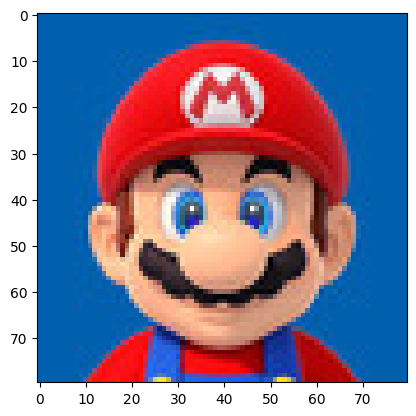

In [7]:
image = cv2.imread('mario_b.jpg')
show_img(image)

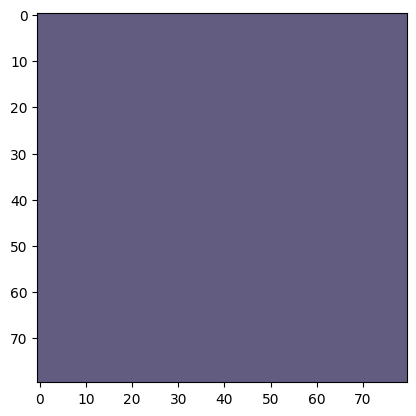

In [8]:
average_color_image = get_img_averaged(image)
show_img(average_color_image)

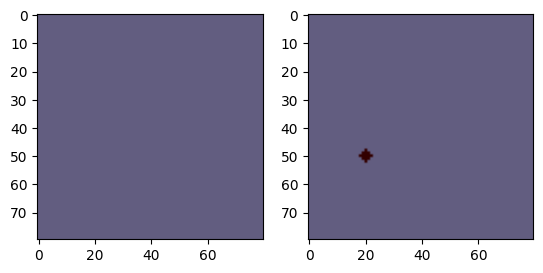

0.54640625


In [9]:
ind = [20,50,2,0,0,50,1]
img_c = draw_circle(average_color_image, *ind)
compare_imgs(average_color_image,img_c)
print(image_difference(average_color_image, img_c))

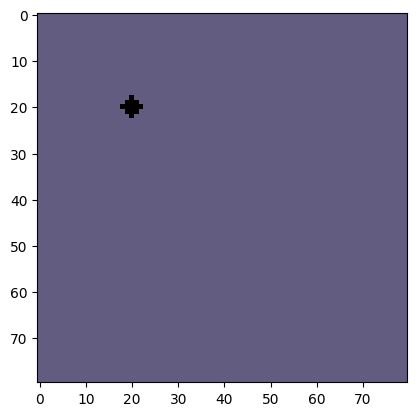

In [10]:
# res =[average_color_image]
img_w_circ = draw_circle(average_color_image, 20,20, 2, 0,0,50, 2)
plt.imshow(cv2.cvtColor(img_w_circ, cv2.COLOR_BGR2RGB))
plt.show()

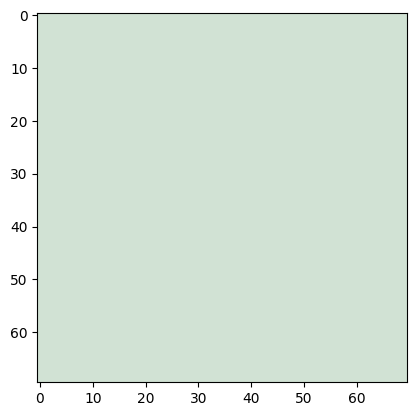

In [11]:
image_obj = cv2.imread('arbol_20.jpg')
curr_img = get_img_averaged(image_obj)
show_img(curr_img)

In [12]:
def solve(img_path, max_it, PRINT_INT:int=None):
    if PRINT_INT is None:
        PRINT_INT = int(max_it//10)

    image_obj = cv2.imread(img_path)
    # curr_img = get_img_averaged(image_obj)
    curr_img = np.ones_like(image_obj) * 255

    max_r = math.sqrt( (image_obj.shape[1]**2) + image_obj.shape[0]**2 )/2
    bounds = [
        [0,image_obj.shape[1]],
        [0,image_obj.shape[0]],
        [4,max_r],
        [0,255], [0,255], [0,255],
        [0,1]
    ]

    DE = DiferentialEvolution(
        target_func, bounds, args=(curr_img, image_obj),
        popsize=500, mutation=(0.5, 2), crossover=0.7,
        maxit=10000, verbose=True
    )

    for i in range(max_it):
        # custom_de = DE_custom(target_func,bounds,args=(curr_img, image_obj),popsize=30,mutation=(0.5,1.9),crossover=0.7,maxit=100,verbose=False)
        custom_de = DE.optimize()
        sol = custom_de['sol']

        curr_img = draw_circle( curr_img, *sol)
        
        if i%PRINT_INT == 0:
            print(f'circle {i+1}: {sol}')
            success = custom_de['success']
            n_it    = custom_de['niter']
            print(f'{target_func(sol, curr_img, image_obj): 0.3f} success:{success} n_it:{n_it}')
            compare_imgs(image_obj, curr_img)
    # end for

    return curr_img

circle 1: [ 61.08379307  52.8625686    5.86863271 127.46413688 202.61343339
 136.0583054    0.83711499]
 120.573 success:True n_it:0


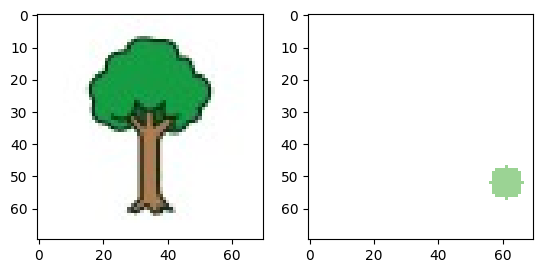

circle 2: [ 46.70120063  65.71354067   8.54174306  59.10372023 112.29095617
 120.78944751   0.37433141]
 125.979 success:True n_it:0


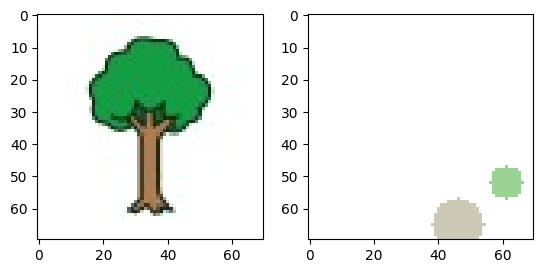

circle 3: [ 39.03460071  52.95766742  37.57509844 232.05248914  66.98604973
  33.99198374   0.96878368]
 270.256 success:True n_it:0


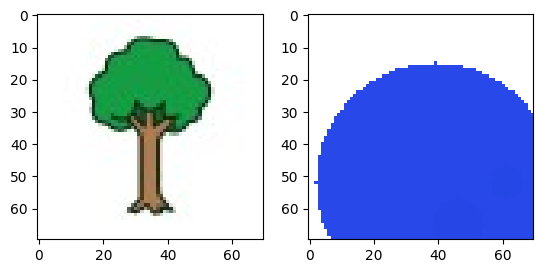

circle 4: [ 30.00358047  16.03175495  25.83965938 222.58934694 225.99313275
 139.12277833   0.35911089]
 271.337 success:True n_it:0


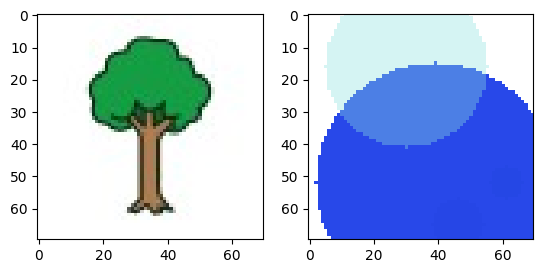

circle 5: [ 10.39512764  13.87050028   8.29923351 195.96118415  39.84617927
 242.8368129    0.83471497]
 279.229 success:True n_it:0


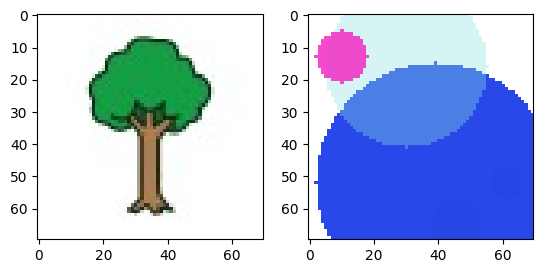

circle 6: [ 64.77680219  59.1544498   36.45971442 226.01440329  36.90113557
 230.16087765   0.62565968]
 254.935 success:True n_it:0


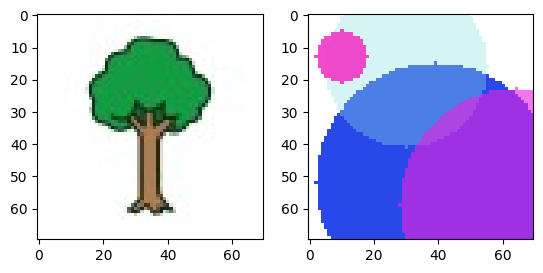

circle 7: [ 41.17873711  49.95898952   9.8714605  125.29005333  82.55560126
 126.01248104   0.94967712]
 257.035 success:True n_it:0


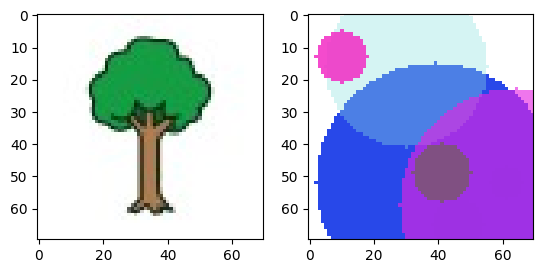

circle 8: [ 21.52263529  29.23536172  49.25639248 168.40369486   1.92575884
 198.14177715   0.70784452]
 340.039 success:True n_it:0


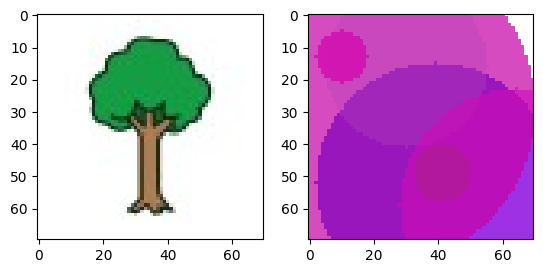

circle 9: [ 44.73467238  25.3562727   24.22196827  19.26482735 139.84608264
  10.93721373   0.58845117]
 329.964 success:True n_it:0


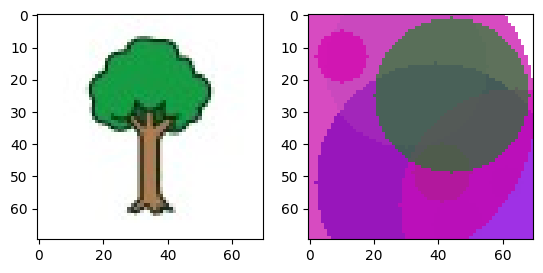

circle 10: [4.65912357e+01 5.12169811e+01 3.18873964e+01 1.19461569e+02
 2.41606394e+02 1.89778961e+02 2.04024483e-01]
 314.688 success:True n_it:0


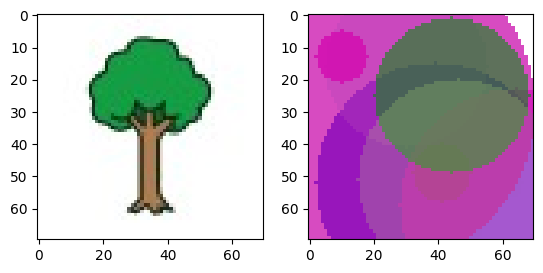

In [13]:
IMAGE_TO_SOLVE = 'arbol_20.jpg'#'mario_b.jpg'
circle_image = solve(IMAGE_TO_SOLVE, 10, PRINT_INT=1)

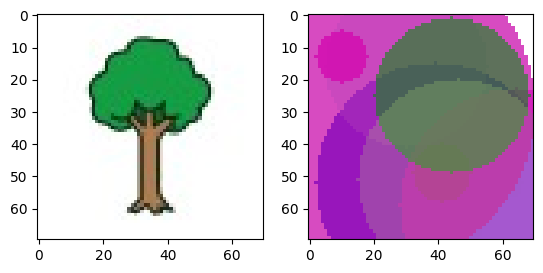

314.68755102040814


In [14]:
original_img = cv2.imread(IMAGE_TO_SOLVE)
compare_imgs(original_img, circle_image)
print(image_difference(original_img, circle_image))